In [1]:
########################################################################################################
####################################### FOR TESTING ####################################################
########################################################################################################

In [2]:
#!/usr/bin/env python3

In [3]:
from gensim.models import Word2Vec
from procrustes import smart_procrustes_align_gensim
import numpy as np
import pandas as pd
from spacy.lang.en import English
from scipy.spatial.distance import cosine
import os
import statistics
nlp = English(pipeline=[])
nlp.add_pipe("sentencizer")

In [4]:
def get_sentences(text: str) -> list[list[str]]:
    """Split the specified text into sentences, consisting of text tokens."""

    sents = []

    # We process the text in chunks by paragraph, ensuring that a sentence
    # never crosses a paragraph boundary:
    for para in text.split("\n\n"):
        doc = nlp(para.replace("\n", " "))
        for sent in doc.sents:
            tokens = [
                token.text.lower().strip() for token in sent if not token.is_space
            ]
            sents.append(tokens)

    return sents

In [5]:
def tokenize(corpus_path : str, corpora_path="corpora"):
    """
    Return a tokenized version of the corpus at corpus_path
    """

    # Read and tokenize corpus from disc
    with open(os.path.join(corpora_path, corpus_path)) as f:
        raw = f.read()
        tokenized = get_sentences(raw)
    
    return tokenized

In [6]:
def get_aligned_embedding_spaces(model1, model2):
    """
    Aligns model2 to model1. Returns embeddings 
    of model1 and aligned model2
    """

    # TODO: ignore words with low frequencies
    # TODO: find ideal threshold

    

    model2_aligned = smart_procrustes_align_gensim(model1, model2)

    print("Embedding spaces aligned")

    embeddings1 = model1.wv
    embeddings2 = model2_aligned.wv


    return (embeddings1, embeddings2)

In [7]:
def get_least_similar(embeddings1, embeddings2, topn=10, all=False) -> dict:
    """
    Return the topn words with the lowest cosine similarity
    across the two embedding spaces and their similarity score.
    """

    print(embeddings1)
    print(embeddings2)

    # Get list of tokens used in both embedding spaces (intersection of both vocabularies)
    vocab = list(set(embeddings1.index_to_key) & set(embeddings2.index_to_key)) 

    # Give option to get all tokens
    if all:
        topn = len(vocab)

    # Filter to only tokens that are in both datasets
    vec1 = {token: embeddings1[token] for token in vocab}
    vec2 = {token: embeddings2[token] for token in vocab}

    # Calculate each token's cosine distance across the two embedding spaces
    # Range 0 --> 2 normalized to 0 --> 1
    distances = {token: cosine(vec1[token], vec2[token]) / 2 for token in vocab}

    # Lower index --> less similar
    least_sim = sorted(distances, key=lambda x: distances[x], reverse=True)

    # Get the vectors of the n least similar words across embedding spaces
    top_n_words = least_sim[:topn]
    top_n_dists = {token: distances[token] for token in top_n_words}

    return top_n_dists




In [ ]:
##### Find ideal min_count parameter for Word2Vec model #####


# Look for ideal parameter in demText, since we're 
# not using it in the actual experiment. This is 
# useful because it avoids selecting words because
# they give interesting results, and puts the focus
# on eliminating tokens that will be harmful to the 
# model. Since we're training on a similar dataset
# (political subreddits),the min_count parameter we 
# find here should extend to the datasets we train on

from collections import Counter
import itertools

t = tokenize("demText.txt", corpora_path="corpora_test")
raw_tokens = itertools.chain.from_iterable(t)
counts = Counter(raw_tokens)

df = pd.DataFrame({"Word": counts.keys(), "Count": counts.values()})

small = df[df["Count"] == 5]

In [ ]:
corpora_filepath = "corpora"  # Use "corpora" when running final experiment
corpora = os.listdir(corpora_filepath)
tokens = {}
models = {}

# For each corpus...

for corpus in corpora:
    # Tokenize the corpus
    t = tokenize(corpus, corpora_path=corpora_filepath)
    # Create an embedding model for the corpus
    # Epochs: 25 --> recommended by Prof
    # Epochs: 4 --> recommended by Hamilton et al.
    # Min_Count: 5 --> standard, wanted to keep as many words as possible
    #                  while avoiding too many hyperlinks or usernames
    model = Word2Vec(t, epochs=25, window=4, min_count=5)
    tokens[corpus] = t
    models[corpus] = model

In [ ]:
# Compare each corpus to each other corpus

corpus_comparisons = []

for corpus1 in corpora:
    for corpus2 in corpora:
        # No point in comparing a corpora's similarity to itself
        if corpus1 == corpus2 or {corpus1, corpus2} in [c["Corpora"] for c in corpus_comparisons]:
            pass
        else:
            
            # Compare two embedding spaces

            print(f"COMPARING: {set((corpus1, corpus2))}")
            
            m1 = models[corpus1]
            m2 = models[corpus2]


            embeddings1, embeddings2 = get_aligned_embedding_spaces(m1, m2)

            print(f"EMBEDDINGS 2: {embeddings2}")
            
            least_similar = get_least_similar(embeddings1, embeddings2, topn=100) # topn chosen arbitrarily

            corpus_comparisons.append({
                "Corpora" : {corpus1, corpus2}, # Since order is not supposed to matter
                "Dissimilarities" : least_similar
            })


            # Display results

            print(f"CORPUS 1: {corpus1}")
            print(f"CORPUS 2: {corpus2}")
            for token in least_similar:
                print(f"TOKEN: {token}    COSINE-DISTANCE: {least_similar[token]}")

COMPARING: {'Ask_Politics.txt', 'geopolitics.txt'}
Embedding spaces aligned
EMBEDDINGS 2: KeyedVectors<vector_size=100, 17283 keys>
KeyedVectors<vector_size=100, 17283 keys>
KeyedVectors<vector_size=100, 17283 keys>
CORPUS 1: geopolitics.txt
CORPUS 2: Ask_Politics.txt
TOKEN: 1996    COSINE-DISTANCE: 0.6570823192596436
TOKEN: hefty    COSINE-DISTANCE: 0.6562101244926453
TOKEN: choke    COSINE-DISTANCE: 0.6464038491249084
TOKEN: payers    COSINE-DISTANCE: 0.6437594890594482
TOKEN: contain    COSINE-DISTANCE: 0.6354101896286011
TOKEN: revisit    COSINE-DISTANCE: 0.6335333585739136
TOKEN: separately    COSINE-DISTANCE: 0.6329596638679504
TOKEN: havens    COSINE-DISTANCE: 0.6315551996231079
TOKEN: sharper    COSINE-DISTANCE: 0.6284252405166626
TOKEN: subjugating    COSINE-DISTANCE: 0.6271243691444397
TOKEN: rolls    COSINE-DISTANCE: 0.6255140900611877
TOKEN: 1986    COSINE-DISTANCE: 0.6240478754043579
TOKEN: annex    COSINE-DISTANCE: 0.6230932474136353
TOKEN: earthers    COSINE-DISTANCE: 0.

In [ ]:
# Collect all of the corpus<-->corpus dissimilarities under each token

token_ids = {}

for comparison in corpus_comparisons:
    
    for token in comparison["Dissimilarities"]:

        if token not in token_ids.keys():
            token_ids[token] = []

        token_ids[token].append(comparison["Dissimilarities"][token]) # Adds the dissimilarity number for that token

# Find the harmonic mean for those dissimilarities
# We find the harmonic mean so that words that vary 
# across only a subset of communities are not weighted 
# too highly

# Tested arithmetic, geometric, harmonic for most "interesting"
# Exclude ridiculously long strings, since they likely don't carry meaning
whole_corpora_dissimilarity = {id: statistics.median(token_ids[id]) for id in token_ids if len(id) < 20}

sorted_distances = sorted(whole_corpora_dissimilarity, key=lambda x: whole_corpora_dissimilarity[x], reverse=True)

# Get the ten highest means
top_distances = sorted_distances

for token in top_distances:
    print(f"TOKEN: {token}    DISSIMILARITY: {whole_corpora_dissimilarity[token]}")




TOKEN: atm    DISSIMILARITY: 0.6852418780326843
TOKEN: 1996    DISSIMILARITY: 0.6570823192596436
TOKEN: hefty    DISSIMILARITY: 0.6562101244926453
TOKEN: defying    DISSIMILARITY: 0.6548773646354675
TOKEN: empowering    DISSIMILARITY: 0.6534193754196167
TOKEN: inform    DISSIMILARITY: 0.6526225209236145
TOKEN: ostracize    DISSIMILARITY: 0.6523689031600952
TOKEN: africans    DISSIMILARITY: 0.6490412950515747
TOKEN: tooth    DISSIMILARITY: 0.6486687660217285
TOKEN: conceding    DISSIMILARITY: 0.6480677723884583
TOKEN: instruct    DISSIMILARITY: 0.6475725173950195
TOKEN: divide    DISSIMILARITY: 0.6467159986495972
TOKEN: lists    DISSIMILARITY: 0.6465268135070801
TOKEN: choke    DISSIMILARITY: 0.6464038491249084
TOKEN: russian    DISSIMILARITY: 0.6461039781570435
TOKEN: rising    DISSIMILARITY: 0.6456000804901123
TOKEN: nationally    DISSIMILARITY: 0.6447283029556274
TOKEN: around    DISSIMILARITY: 0.644599974155426
TOKEN: payers    DISSIMILARITY: 0.6437594890594482
TOKEN: nervous    DIS

In [ ]:
targets = []
words = []
values = []
communities = []

# For each "interesting" word
for target in top_distances:

    # For each corpus
    for c in corpora:
        
        embedding = models[c].wv

        try:
            # Find topn closest words in the semantic space
            for word, value in embedding.most_similar(target, topn=10):
                targets.append(target)
                words.append(word)
                values.append(value)
                communities.append(c)
        except KeyError:
            # Catch potential outlier in targets
            print(f"Word '{target}' not in {c}")


df = pd.DataFrame({
    "Community" : communities,
    "Word" : targets,
    "Neighbor" : words,
    "Similarity" : values
})

In [ ]:
df

,Community,Word,Neighbor,Similarity
0,geopolitics.txt,atm,tbh,0.482101
1,geopolitics.txt,atm,now,0.479021
2,geopolitics.txt,atm,currently,0.420016
3,geopolitics.txt,atm,hah,0.394792
4,geopolitics.txt,atm,nowadays,0.391532
...,...,...,...,...
81535,PoliticalDiscussion.txt,burma,qatar,0.702468
81536,PoliticalDiscussion.txt,burma,brazil,0.701625
81537,PoliticalDiscussion.txt,burma,guatemala,0.700388
81538,PoliticalDiscussion.txt,burma,nigeria,0.698532


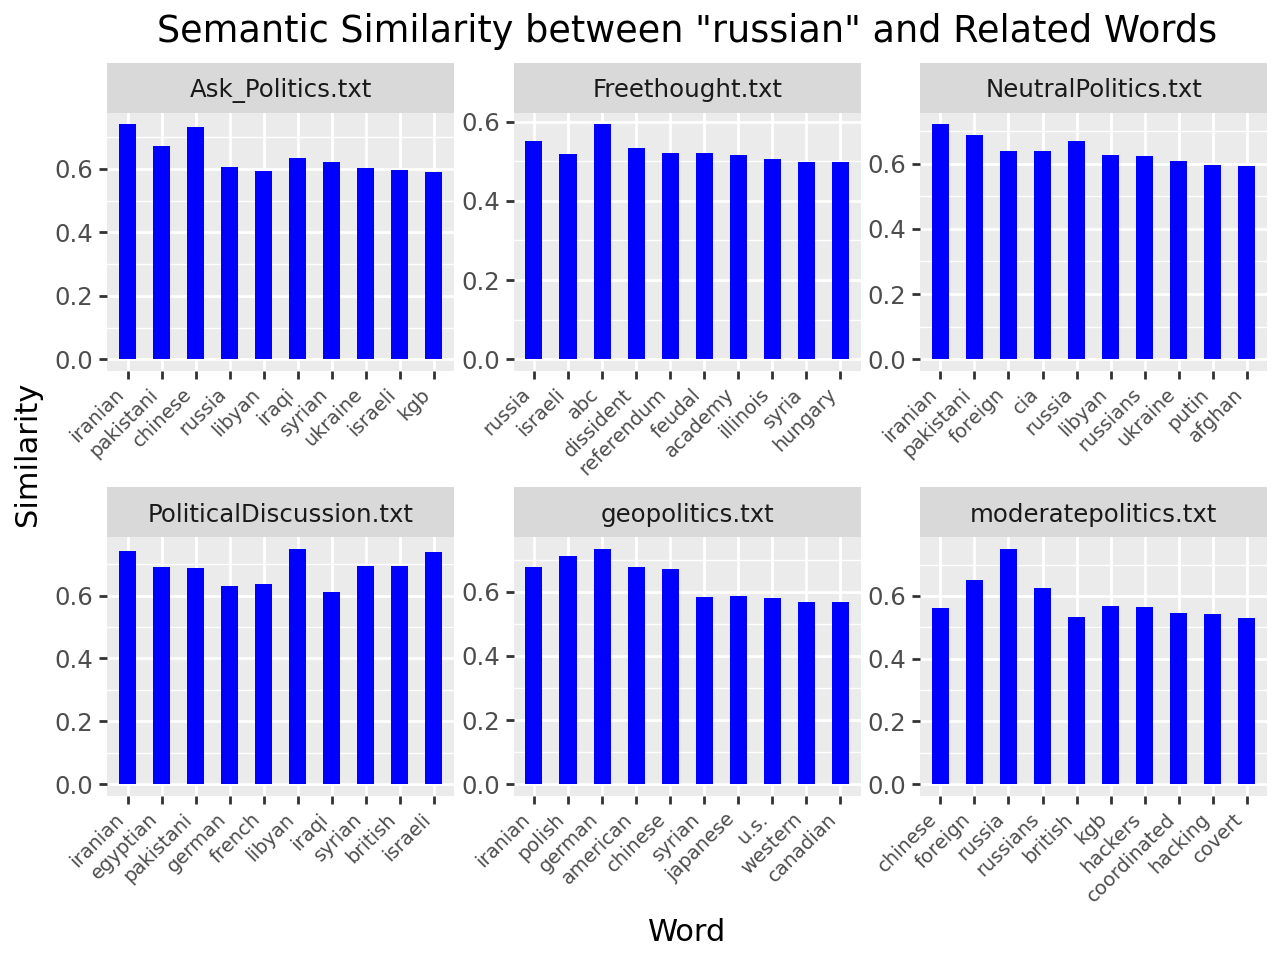

/home/jchidiac/.conda/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:623: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/jchidiac/.conda/envs/nlp/lib/python3.11/site-packages/plotnine/ggplot.py:624: PlotnineWarning: Filename: plots/russian.png


In [ ]:
from plotnine import ggplot, aes, geom_col, scale_fill_manual, labs, element_text, theme, facet_wrap, element_blank, element_rect

# Choose a word based on intuition from the "interesting" words (top_distances)
TARGET = "russian"
df_target = df[df["Word"] == TARGET]

# Make a graph!
p = (ggplot(df_target, aes(x="reorder(Neighbor, Similarity, ascending=False)", y="Similarity", fill="Community")) +
 geom_col(width=0.5, position="dodge") +
 scale_fill_manual(values=np.repeat(["blue"], len(corpora))) +
 labs(x="Word", title=f'Semantic Similarity between "{TARGET}" and Related Words') +
 facet_wrap("~Community", scales="free") +
 theme(axis_text_x=element_text(angle=45, hjust=1, vjust=1, size=7), 
       legend_position="none")
)

p.show()

p.save(f"plots/{TARGET}.png")